In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.1.2


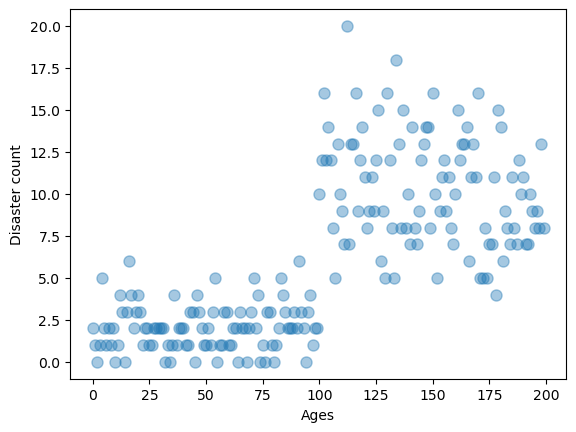

In [5]:
# fmt: off
from numpy import random 

data1 = random.poisson(lam = 2, size = 100)
data2 = random.poisson(lam = 10, size = 100)

zircons_data = np.concatenate([data1,data2])
ages_nominal = np.arange(0, 200)

plt.plot(ages_nominal, zircons_data, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Ages");

In [6]:
with pm.Model() as zircons_model:
    switchpoint = pm.DiscreteUniform("switchpoint", lower=ages_nominal.min(), upper=ages_nominal.max())

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= ages_nominal, early_rate, late_rate)

    disasters = pm.Poisson("counts", rate, observed=zircons_data)

In [7]:
with zircons_model:
    idata = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [early_rate, late_rate]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 30 seconds.


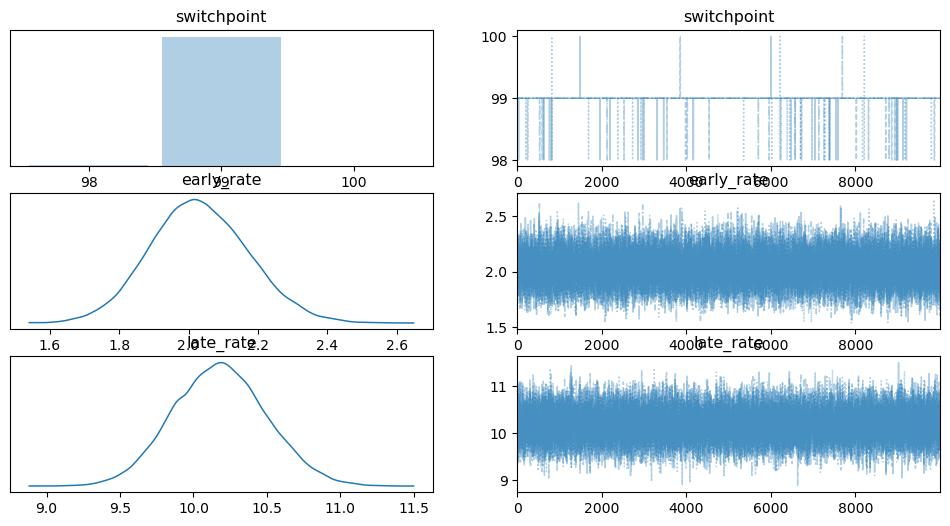

In [8]:
az.plot_trace(idata, combined=True);

In [9]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
switchpoint,98.99,0.09,99.00,99.00,0.0,0.0,6710.83,7035.42,1.0
early_rate,2.03,0.14,1.77,2.30,0.0,0.0,44075.88,30612.37,1.0
late_rate,10.18,0.32,9.59,10.78,0.0,0.0,41822.72,29870.20,1.0


In [13]:
tr =pm.distributions.transforms

Order = tr.Ordered()

In [14]:
with pm.Model() as model:
    
    k =1
    
    rates = pm.Exponential("rates",1.0,shape = k + 1)
    
    switchpoints = pm.Uniform("switchpoints", lower = 0, upper = max(ages_nominal) , shape = k, transform = Order,  initval=np.linspace(1,199,k))
    #x = pm.Uniform("x", 0.0, 1.0, shape = n, transform = chain_tran)
    rate = rates[0]
    for i in range(k):
        rate = pm.math.switch(switchpoints[i] >= ages_nominal, rate, rates[i+1])
        
    disasters = pm.Poisson("counts", rate, observed=zircons_data)
    
    tr50000 = pm.sample(draws =5000,tune = 5000, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [rates, switchpoints]


Sampling 2 chains for 5_000 tune and 5_000 draw iterations (10_000 + 10_000 draws total) took 2436 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rates[0],2.032,0.141,1.776,2.301,0.003,0.002,2731.0,3636.0,1.0
rates[1],10.165,0.317,9.566,10.750,0.007,0.005,2368.0,3293.0,1.0
switchpoints[0],99.499,0.304,99.058,99.998,0.007,0.005,2188.0,2442.0,1.0


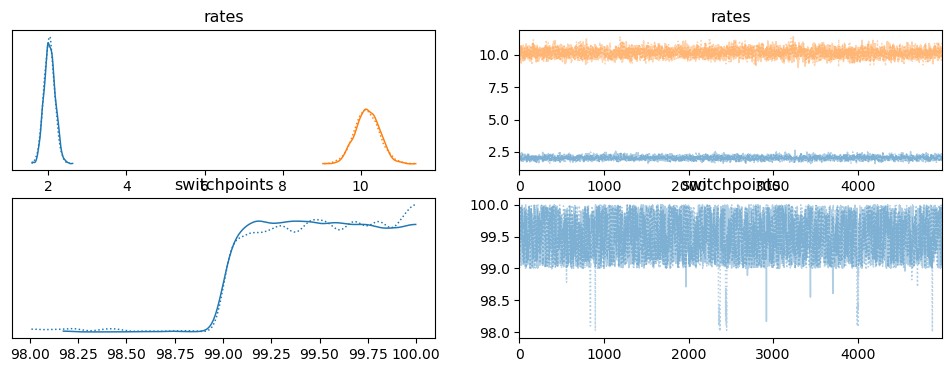

In [15]:
with model:
    az.plot_trace(tr50000)
    
pm.summary(tr50000)